In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matchPics import matchPics
from helper import plotMatches
from planarH import warped
from planarH import computeH, computeH_ransac, computeH_ransac_adaptive

In [2]:
cv_cover = cv2.imread('../data/cv_cover.jpg')
cv_desk = cv2.imread('../data/cv_desk.png')

## OpenCV ORB

In [3]:
# Load images
# Detect keypoints and extract descriptors
orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(cv_cover, None)
kp2, des2 = orb.detectAndCompute(cv_desk, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1, des2)

pts1 = np.float32([kp1[m.queryIdx].pt for m in matches_cv]).reshape(-1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches_cv]).reshape(-1, 2)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

# Select the top 10% accurate matches
num_matches_10 = int(len(matches_cv) * 0.40)  # choose 10% of total matches
best_matches_10 = matches_cv[:num_matches_10]

pts1_best_10 = np.float32([kp1[m.queryIdx].pt for m in best_matches_10]).reshape(-1, 2)
pts2_best_10 = np.float32([kp2[m.trainIdx].pt for m in best_matches_10]).reshape(-1, 2)


num_matches_50 = int(len(matches_cv) * 0.5)  # choose 10% of total matches
best_matches_50 = matches_cv[:num_matches_50]

pts1_best_50 = np.float32([kp1[m.queryIdx].pt for m in best_matches_50]).reshape(-1, 2)
pts2_best_50 = np.float32([kp2[m.trainIdx].pt for m in best_matches_50]).reshape(-1, 2)


### 내코드

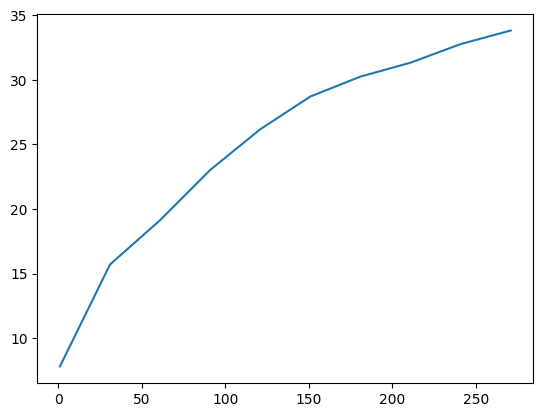

In [13]:
# number of iteration
ransac = np.array([])
inlier_sample = np.array([])
iter_arr = np.array([])

locs1 = pts2_best_50
locs2 = pts1_best_50

n = locs1.shape[0]

for iter in range(1, 300, 30):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2, pts1, iter)
        
        num_inliers = np.sum(inliers)

        inlier_sample = np.append(inlier_sample, np.array([num_inliers]), axis=0)

    #print(inlier_sample)
    inlier_avg = np.mean(inlier_sample)
    #print(inlier_avg)
    ransac = np.append(ransac, [inlier_avg], axis=0)
    iter_arr = np.append(iter_arr, [iter], axis=0)

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()

### threshold 4, 3000번

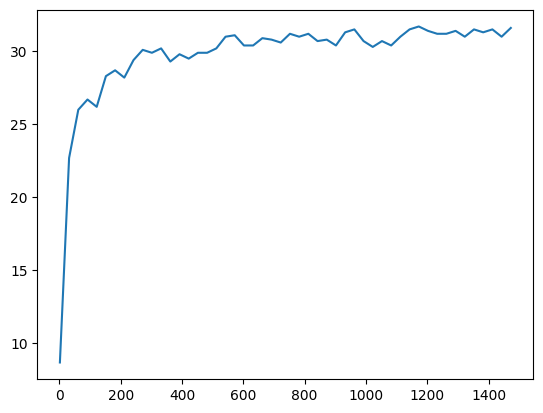

In [4]:
inlier_sample = np.zeros((10,))
iter_arr = np.arange(2, 1500, 30)
ransac = np.zeros((len(iter_arr),))
locs1 = pts2_best_50
locs2 = pts1_best_50

n = locs1.shape[0]

for iter_idx, iter in enumerate(iter_arr):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best_10, pts1_best_10, iter, inlier_tol = 4)
        num_inliers = np.sum(inliers)
        inlier_sample[i] = num_inliers

    inlier_avg = np.mean(inlier_sample)
    ransac[iter_idx] = inlier_avg

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()

### Experiments

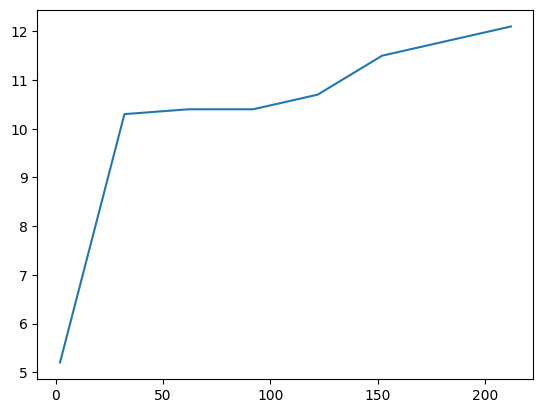

In [140]:
inlier_sample = np.zeros((10,))
iter_arr = np.arange(2, 240, 30)
ransac = np.zeros((len(iter_arr),))
locs1 = pts2_best_50
locs2 = pts1_best_50

n = locs1.shape[0]

for iter_idx, iter in enumerate(iter_arr):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best_10, pts1_best_10, iter, inlier_tol = 1.2)
        num_inliers = np.sum(inliers)
        inlier_sample[i] = num_inliers

    inlier_avg = np.mean(inlier_sample)
    ransac[iter_idx] = inlier_avg

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()

### Visualization

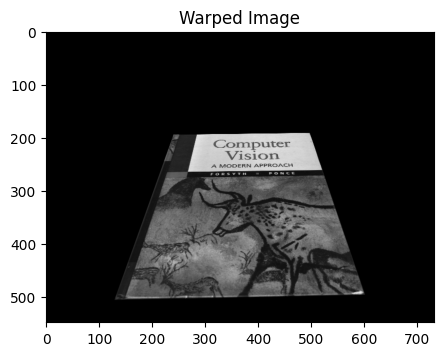

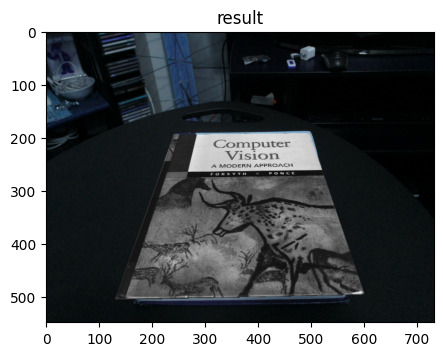

In [32]:
h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()

result = warped(H2to1, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

### TEST

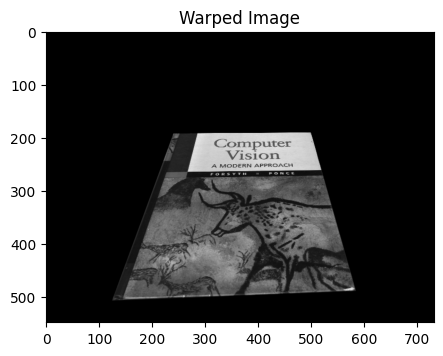

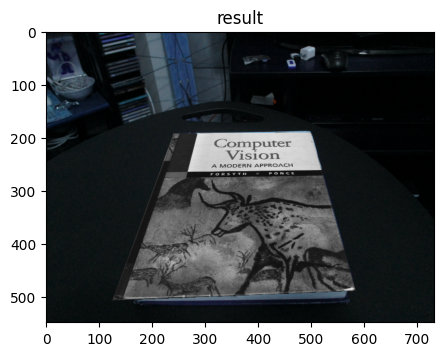

In [139]:
# Compute homography matrix
#H2to1_ransac, inliers = cv2.findHomography(pts1_best_30, pts2_best_30"=, cv2.RANSAC, 5.0)
H2to1_ransac, inliers = computeH_ransac(pts2_best_10, pts1_best_10, 300, inlier_tol = 4)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1_ransac, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()

result = warped(H2to1_ransac, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

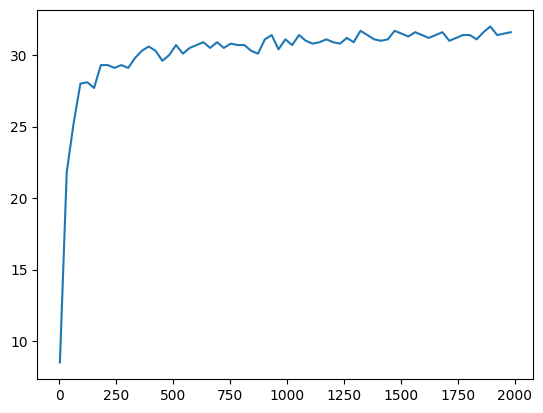

In [138]:
inlier_sample = np.zeros((10,))
iter_arr = np.arange(2, 2000, 30)
ransac = np.zeros((len(iter_arr),))
locs1 = pts2_best_50
locs2 = pts1_best_50

n = locs1.shape[0]

for iter_idx, iter in enumerate(iter_arr):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best_10, pts1_best_10, iter, inlier_tol = 4)
        num_inliers = np.sum(inliers)
        inlier_sample[i] = num_inliers

    inlier_avg = np.mean(inlier_sample)
    ransac[iter_idx] = inlier_avg

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()

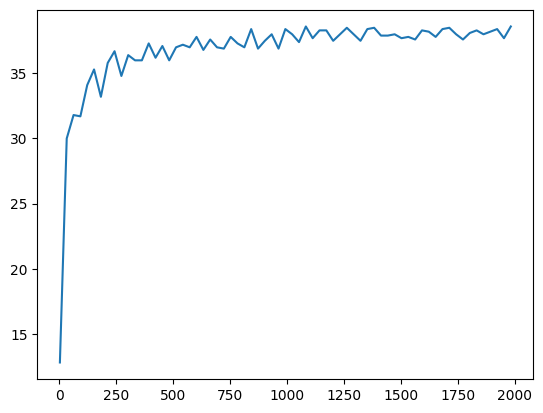

In [135]:
inlier_sample = np.zeros((10,))
iter_arr = np.arange(2, 2000, 30)
ransac = np.zeros((len(iter_arr),))
locs1 = pts2_best_50
locs2 = pts1_best_50

n = locs1.shape[0]

for iter_idx, iter in enumerate(iter_arr):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best_50, pts1_best_50, iter, inlier_tol = 4)
        num_inliers = np.sum(inliers)
        inlier_sample[i] = num_inliers

    inlier_avg = np.mean(inlier_sample)
    ransac[iter_idx] = inlier_avg

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()